In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [3]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [4]:
datasize = 100
max_document_length = 256

index = -1
train_docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if (not status) or (max_document_length is not None and len(doc) > max_document_length):
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [5]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: rec.autos
apparently you re not a woman my husband hate the auto door lock feel safer in a car that lock easily in addition to watch around in a seclude spot etc have my key ready to open the door so i m


In [6]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[100, 100, 100, 100]


In [7]:
print(f"there are {len(train_docs)} docs")

there are 400 docs


### Initialize Vectorizer

In [8]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 2727


### Prepare Datatset

In [9]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

400 train_docs


### Word-Word Ratio

In [59]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T
probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
    pmi = np.log2(pxy / (probability[word] * probability))
    
    pmi = pmi.replace([np.inf, -np.inf], 0)
    pmi = pmi.fillna(0)
    
    dev = pmi - pmi.min()
    word_word_co[word] = dev / dev.sum()

# word_word_co = (word_word_co.T / word_word_co.sum(1)).T
print(f"word_word_co has shape {word_word_co.shape}")

c:\users\christian\documents\christian\work\python\cyberspace\topic_modeler\venv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)



word_word_co has shape (2727, 2727)


In [60]:
word_word_co.head()

,00,000,0098,020359,031349,0878,0b1fatransfer,10,1000,10k,...,you,your,yours,yourself,yourselves,ypu,yup,zbib,zeuge,zuma
00,0.070043,0.000312,0.000000,0.000000,0.000000,0.0,0.0,0.002954,0.000284,0.00033,...,0.000298,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.000000,0.003021,0.000000,0.000000,0.000000,0.0,0.0,0.002210,0.000284,0.00033,...,0.000490,0.000490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0098,0.000000,0.000312,0.054181,0.000000,0.000000,0.0,0.0,0.000329,0.000284,0.00033,...,0.000298,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020359,0.000000,0.000312,0.000000,0.040777,0.000000,0.0,0.0,0.000329,0.000284,0.00033,...,0.000298,0.000294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
031349,0.000000,0.000312,0.000000,0.000000,0.048983,0.0,0.0,0.000329,0.000284,0.00033,...,0.000557,0.000811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate Word Trust ratio

In [61]:
word_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]

pivot_entropy = word_entropy
pivot_entropy = (pivot_entropy - pivot_entropy.mean())

word_weight = pd.DataFrame(data=gaussian(pivot_entropy), columns=[0], index=vocabulary)[0]

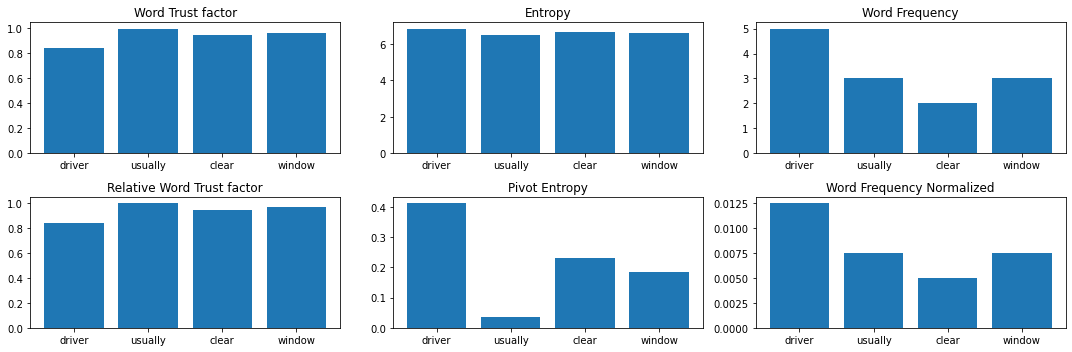

In [62]:
# words = ["israel", "the", "algorithm", "program", "and"]
words = ["driver", "usually", "clear", "window"]
# words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]

fig = plt.figure(figsize=(15,5), tight_layout=True)
ax11 = fig.add_subplot(231)
ax12 = fig.add_subplot(232)
ax13 = fig.add_subplot(233)
ax21 = fig.add_subplot(234)
ax22 = fig.add_subplot(235)
ax23 = fig.add_subplot(236)

ax11.set_title(f"Word Trust factor")
ax11.bar(words, word_weight[words])

ax12.set_title(f"Entropy")
ax12.bar(words, word_entropy[words])

ax13.set_title(f"Word Frequency")
ax13.bar(words, word_freq_in_doc.sum(0)[words])

word_weight = word_weight / word_weight.max()

ax21.set_title(f"Relative Word Trust factor")
ax21.bar(words, word_weight[words])

ax22.set_title(f"Pivot Entropy")
ax22.bar(words, abs(pivot_entropy)[words])

ax23.set_title(f"Word Frequency Normalized")
ax23.bar(words, (probability)[words])

plt.show()

In [63]:
word_weight.sort_values(ascending=False).head(5)

reporting     1.0
bias          1.0
propaganda    1.0
goering       1.0
press         1.0
Name: 0, dtype: float64

### Observe word_word_co ratios

In [15]:
wwc = (word_word_co * word_weight)

=== Ploting software against ['driver', 'usually', 'clear', 'window'] ===


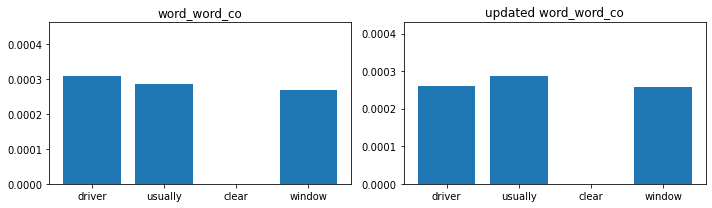

In [16]:
word = "software"

fig = plt.figure(figsize=(10,3), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

print(f"=== Ploting {word} against {words} ===")

values = word_word_co.loc[word][words]
ax1.set_title(f"word_word_co")
ax1.set_ylim(0, 1.5*values.max())
ax1.bar(words, values)

values = wwc.loc[word][words]
ax2.set_title(f"updated word_word_co")
ax2.set_ylim(0, 1.5*values.max())
ax2.bar(words, values)

plt.show()

In [17]:
wwc.loc["war"].sort_values(ascending=False).head(10)

civil       0.072930
war         0.072930
currency    0.072930
coin        0.072930
various     0.034879
require     0.030262
motto       0.008162
50          0.005253
since       0.002067
didn        0.001214
Name: war, dtype: float64

In [18]:
word_word_co.loc["war"].sort_values(ascending=False).head(10)

war         0.089770
currency    0.089770
coin        0.089770
civil       0.089770
various     0.037669
require     0.031299
motto       0.008694
50          0.005601
since       0.002068
didn        0.001658
Name: war, dtype: float64

### Update word_word_co with word_word_co

In [19]:
word_word_co = wwc.copy()

### Setup Doc Word Distr

In [72]:
doc_word_distr = word_doc_frequency_norm * word_weight

In [73]:
doc_word_distr.head()

,00,000,0098,020359,031349,0878,0b1fatransfer,10,1000,10k,...,you,your,yours,yourself,yourselves,ypu,yup,zbib,zeuge,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
doc_index = 120
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(10)

to          0.069767
the         0.069767
it          0.069767
charon      0.046512
shadow      0.046512
and         0.046512
of          0.046512
due         0.046512
pluto       0.046512
distance    0.023256
Name: 120, dtype: float64

In [99]:
doc_word_distr.loc[doc_index].sort_values(ascending=False)

shadow     0.046387
pluto      0.045477
charon     0.045477
due        0.043808
orbit      0.023231
             ...   
pause      0.000000
paul       0.000000
patrick    0.000000
pastor     0.000000
00         0.000000
Name: 120, Length: 2727, dtype: float64

In [100]:
(doc_word_distr.loc[doc_index] * word_word_co.T).sum(1).sort_values(ascending=False).head(10)

occur         0.022684
versa         0.022684
pluto         0.022684
george        0.022684
distance      0.022684
charon        0.022684
krumins       0.022684
elliptical    0.022684
sun           0.022684
freeze        0.022684
dtype: float64

In [101]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: sci.space
it s my understand that the freeze will start to occur because of the grow distance of pluto and charon from the sun due to it s elliptical orbit it be not due to shadow effect pluto can shadow charon and vice versa george krumins


In [23]:
for di in range(len(doc_word_distr.index)):
    print(doc_word_distr.iloc[di].sort_values(ascending=False).head(5).index.to_list())
    break

['lock', 'door', 'woman', 'apparently', 'key']


In [102]:
dwd = doc_word_distr * 0

for doc_index in tqdm(range(len(doc_word_distr))):
    dwd.loc[doc_index] = (doc_word_distr.loc[doc_index] * word_word_co.T).sum(1)

doc_word_distr = dwd

In [103]:
doc_word_distr = dwd

### Define Latent partitions

In [140]:
# reduction = None
reduction = "pca"
# reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 2
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components, whiten=True)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.mean(1), doc_word_distr.std(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (400, 2)


In [141]:
distr_params.head()

,0,1
0,-0.077801,-0.255003
1,0.042138,0.024511
2,-0.133528,-0.085143
3,-0.169421,-0.165796
4,-0.171291,0.450158


In [142]:
doc_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(doc_word_distr.T, base=2)), columns=[0], index=distr_params.index)[0]

# doc_weight = pd.DataFrame(data=gaussian2(doc_entropy), columns=[0], index=distr_params.index)[0]
doc_weight = pd.DataFrame(data=gaussian(doc_entropy - doc_entropy.mean()), columns=[0], index=distr_params.index)[0]

doc_weight = doc_weight / doc_weight.sum()

In [143]:
doc_index = doc_weight.argmin()
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: rec.autos
ites


In [144]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(10)

ites         1.835613e-07
loser        6.611702e-11
message      6.526741e-11
23           6.455430e-11
retard       6.436886e-11
objective    6.422573e-11
hey          6.379765e-11
hillary      6.352501e-11
cheat        6.352501e-11
let          6.323682e-11
Name: 254, dtype: float64

In [145]:
doc_index = doc_weight.argmax()
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: sci.space
how can you tell they re identical you get one of them star drek the next syndication neutrino scanner


In [146]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(10)

syndication    0.027260
identical      0.027260
scanner        0.027260
neutrino       0.027260
drek           0.027260
enlighten      0.005072
karla          0.005023
ironic         0.004043
contridict     0.003561
negation       0.003561
Name: 221, dtype: float64

In [147]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: sci.space
how can you tell they re identical you get one of them star drek the next syndication neutrino scanner


### Using Kmeans MiniBatch

In [148]:
num_of_topics = 4

In [149]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)
# kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params, sample_weight=distr_params.std(1))
# kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params, sample_weight=doc_weight)

In [150]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (400, 4), predicted_labels has shape (400,)


In [151]:
Counter(predicted_labels)

Counter({0: 388, 2: 2, 3: 8, 1: 2})

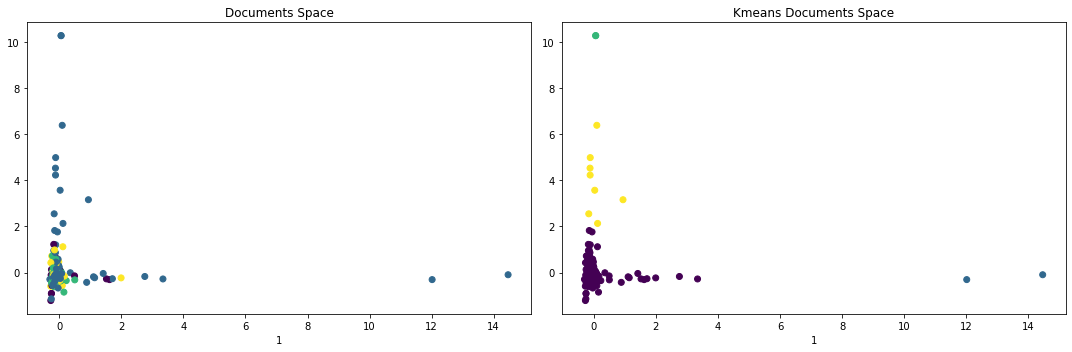

In [152]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Documents Space")
ax1.scatter(param_values[:, 0], param_values[:,1], c = label_indices)
ax1.set_xlabel(columns[0])
ax1.set_xlabel(columns[1])

ax2.set_title("Kmeans Documents Space")
ax2.scatter(param_values[:, 0], param_values[:,1], c = predicted_labels)
ax2.set_xlabel(columns[0])
ax2.set_xlabel(columns[1])

plt.show()

In [153]:
voc_array = np.array(vocabulary)

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [136]:
get_top(0)

Counter({'talk.politics.mideast': 4})
birthday      0.033305
45th          0.033305
hillel        0.015009
berkeley      0.015009
messy         0.015009
tonight       0.015009
rubenstein    0.015009
pm            0.015009
wednesday     0.015009
campus        0.015009
dtype: float64


In [137]:
get_top(1)

Counter({'talk.politics.mideast': 2})
dear          0.101988
clearify      0.095038
alumnus       0.011809
graduate      0.011809
yourselves    0.011809
keefe         0.011809
directory     0.011809
anywhere      0.011809
educate       0.011809
particular    0.011795
dtype: float64


In [138]:
get_top(2)

Counter({'rec.autos': 100, 'alt.atheism': 100, 'sci.space': 98, 'talk.politics.mideast': 93})
enlighten     0.000720
breathing     0.000659
pollard       0.000641
rich          0.000612
inbreeding    0.000578
trash         0.000578
yare          0.000577
bore          0.000565
incredibly    0.000565
calibra       0.000558
dtype: float64


In [139]:
get_top(3)

Counter({'sci.space': 2, 'talk.politics.mideast': 1})
asshole      0.040099
26996        0.013957
msb          0.013957
brader       0.013957
apoapsis     0.013957
1993apr19    0.013957
020359       0.013957
unlikely     0.013957
periapsis    0.013957
sq           0.013957
dtype: float64


### LDA